# Creating NEMO files for unit test of grid object in oocgcm. 

 - **author** : Julien Le Sommer, CNRS
 - **date** : May 2016
 - **purpose** : create lightweight NEMO-like byte_mask and mesh_hgr files for oocgcm. 
 - **method** : use ocgcm.griddeddata.grids. (caution : oocgcm returns only 2d grids but reads from 3d byte_mask array...)
 - **status** : works but the output files still lack some metadata.
 - **remark** : the creation of grid object from NEMO files is too sensitive to the detail of the presence of the time dimension. 

### Parameters

In [1]:
coordfile = '/Users/lesommer/tmp/nemo-oocgcm-testdata_coordinates.nc'
maskfile = '/Users/lesommer/tmp/nemo-oocgcm-testdata_byte_mask.nc'
#resolution = 0.04
jpi=50
jpj=40
jpk=3

### Creates the arrays

In [2]:
#- imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
from oocgcm.griddeddata import grids as agrids
from oocgcm.oceanmodels.nemo import grids as fgrids
#- import nemo dictionnary of variables 
from oocgcm.oceanmodels.nemo.grids import _nemo_keymap_projection_coordinates
from oocgcm.oceanmodels.nemo.grids import  _nemo_keymap_horizontal_metrics
from oocgcm.oceanmodels.nemo.grids import  _nemo_keymap_byte_mask

In [3]:
#- creates the grid
#lon = np.arange(start=-20, stop=0, step=resolution,dtype=float)
#lat = np.arange(start=30, stop=48, step=resolution,dtype=float)
lon = np.linspace(-20,0,jpi)
lat = np.linspace(30,48,jpj)
lon2d,lat2d = np.meshgrid(lon,lat)

In [4]:
#- defines the mask
_mask = (lon2d>-15) * (lon2d<-12) * (lat2d>38) * (lat2d<40) \
      + (lon2d>-13) * (lon2d<-12) * (lat2d>40) * (lat2d<44) \
      + (lon2d>-6) * (lon2d<-5) * (lat2d>32) * (lat2d<33) \
      + (lon2d<-19.) \
      + (lat2d> 47.)
tmask = np.array(True - _mask,dtype=float)
#plt.pcolormesh(lon2d,lat2d,tmask)

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel-4.3.1-py2.7.egg/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  app.launch_new_instance()


/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


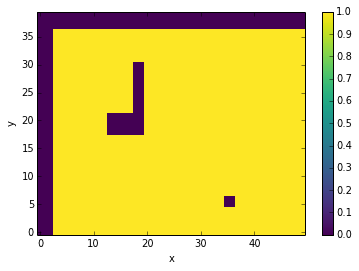

In [5]:
agrd = agrids.latlon_2d_grid(latitudes=lat2d,longitudes=lon2d,mask=tmask)
agrd.arrays['sea_binary_mask_at_t_location'].plot()

In [6]:
#- remove indication of grid_location for netCDF file
del agrd.arrays['projection_x_coordinate_at_t_location'].attrs['grid_location']
del agrd.arrays['projection_y_coordinate_at_t_location'].attrs['grid_location']

### Writes  "nemo-oocgcm-testdata_byte_mask.nc" and "nemo-oocgcm-testdata_coordinates.nc"


In [7]:
_nemo_keymap_coordinates = dict(_nemo_keymap_projection_coordinates.items() + _nemo_keymap_horizontal_metrics.items())

In [8]:
for nemoname,stdname in _nemo_keymap_coordinates.iteritems():
    print "nemo name '" + nemoname + "' corresponds to standart name '" + stdname + "'"

nemo name 'e2t' corresponds to standart name 'cell_y_size_at_t_location'
nemo name 'e2u' corresponds to standart name 'cell_y_size_at_u_location'
nemo name 'e2v' corresponds to standart name 'cell_y_size_at_v_location'
nemo name 'nav_lat' corresponds to standart name 'projection_y_coordinate_at_t_location'
nemo name 'e1u' corresponds to standart name 'cell_x_size_at_u_location'
nemo name 'e2f' corresponds to standart name 'cell_y_size_at_f_location'
nemo name 'e1t' corresponds to standart name 'cell_x_size_at_t_location'
nemo name 'nav_lon' corresponds to standart name 'projection_x_coordinate_at_t_location'
nemo name 'e1v' corresponds to standart name 'cell_x_size_at_v_location'
nemo name 'e1f' corresponds to standart name 'cell_x_size_at_f_location'


In [9]:
#- creates the Dataset of coordinates
coordinates_dict = dict([(nemoname,agrd.arrays[stdname]) for nemoname,stdname in _nemo_keymap_coordinates.iteritems()])
coordinates_dataset = xr.Dataset(coordinates_dict)
coordinates_dataset.attrs['history'] = """Demonstration NEMO-like coordinate file."""
coordinates_dataset.to_netcdf(coordfile,format='NETCDF3_CLASSIC')

In [10]:
def expand3d(dataarray):
    array = np.array(dataarray.to_masked_array())
    rsh = array.reshape((1,jpj,jpi)).repeat(jpk,axis=-3).reshape((jpk,jpj,jpi))
    return xr.DataArray(rsh,dims=['z','y','x'])

byte_mask_dict = dict([(nemoname,expand3d(agrd.arrays[stdname])) \
                       for nemoname,stdname in _nemo_keymap_byte_mask.iteritems()])
bytemask_dataset = xr.Dataset(byte_mask_dict)
bytemask_dataset.attrs['history'] = """Demonstration NEMO-like byte_mask file."""
bytemask_dataset.to_netcdf(maskfile,format='NETCDF3_CLASSIC')

### Test the creation of a grid object from the two files 

In [11]:
#chunk_size = {'z':3,'y':20,'x':20}
fgrd =  fgrids.nemo_2d_grid(nemo_coordinate_file=coordfile,nemo_byte_mask_file=maskfile)#,chunks=chunk_size)

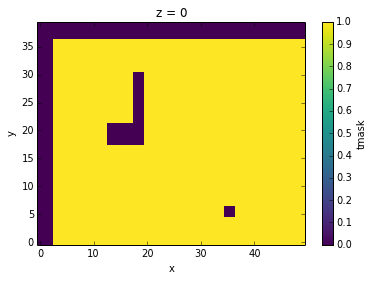

In [12]:
fgrd.arrays['sea_binary_mask_at_t_location'].plot()